In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

import gc
import scipy.stats as st
from decimal import ROUND_UP, ROUND_DOWN
import warnings
import market_making_functions as mmf
from functools import reduce

warnings.filterwarnings('ignore')

In [2]:
undly_price = pd.read_excel('510300 price test.xlsx')
option_info = pd.read_excel('option basic info test.xlsx')
option_info = option_info[['Code','exe_mode','exe_price','lasttradingdate']]
file_dates = undly_price['time'].dt.date.drop_duplicates().reset_index(drop=True)
file_names = option_info['Code']

In [3]:
option_price_all = []
for date in file_dates:
    option_price = []
    for file_name in file_names:
        try:
            daily_option_price = pd.read_csv('option_price/'+str(dt.datetime.strftime(date, "%Y%m%d"))+'/'+str(file_name)+'.csv')
            daily_option_price['Datetime']= daily_option_price['Time'].astype(str).apply(lambda x:x[:-7])
            
            daily_option_price['reftime'] = daily_option_price['Datetime'].astype(str).apply(lambda x:x[-5:])
            daily_option_price =daily_option_price[(daily_option_price['reftime'] >= '09:30')&(daily_option_price['reftime'] <= '14:55')]
            
            daily_option_price['Code'] = file_name
            daily_option_price = pd.merge(daily_option_price, option_info,on='Code',how='inner')
            
            daily_option_price = daily_option_price[['Time', 'exe_mode', 'lasttradingdate', 'exe_price', 
                                                    'TotalVol', 'SP1', 'SV1', 'BP1', 'BV1']]
            daily_option_price[['SP1','SV1','BP1','BV1']] = daily_option_price[['SP1','SV1','BP1','BV1']].replace(0,np.nan)
            daily_option_price = daily_option_price.fillna(method='ffill')
            
            daily_option_price.lasttradingdate = daily_option_price.lasttradingdate.astype(str)

            daily_option_price['mid_price'] = (daily_option_price['SP1'] + daily_option_price['BP1'])/2
            option_price.append(daily_option_price)
        except Exception: 
            pass
    daily_option_price_all = pd.concat(option_price,ignore_index=True)
    option_price_all.append(daily_option_price_all)
option_price_all = pd.concat(option_price_all,ignore_index=True)

In [4]:
test = option_price_all[(option_price_all['Time']>'2023-05-04 09:30:00.000')&(option_price_all['Time']<'2023-05-12 14:55:00.000')].reset_index(drop=True)

In [5]:
put_data_1, call_data_1 = mmf.data_preprocessing('2023-05-24', test)
put_data_2, call_data_2 = mmf.data_preprocessing('2023-06-28', test)
put_data_3, call_data_3 = mmf.data_preprocessing('2023-09-27', test)
put_data_4, call_data_4 = mmf.data_preprocessing('2023-12-27', test)

In [7]:
otm_put_1, otm_call_1 = mmf.solve_implied_vols_vega(put_data_1, call_data_1)
otm_put_2, otm_call_2 = mmf.solve_implied_vols_vega(put_data_2, call_data_2)
otm_put_3, otm_call_3 = mmf.solve_implied_vols_vega(put_data_3, call_data_3)
otm_put_4, otm_call_4 = mmf.solve_implied_vols_vega(put_data_4, call_data_4)

In [10]:
polyfit_vols_1 = mmf.polyfit_vols(otm_put_1, otm_call_1)
polyfit_vols_2 = mmf.polyfit_vols(otm_put_2, otm_call_2)
polyfit_vols_3 = mmf.polyfit_vols(otm_put_3, otm_call_3)
polyfit_vols_4 = mmf.polyfit_vols(otm_put_4, otm_call_4)

In [11]:
# 每个月份的Smooth ATM Vol记为Vol1...4，对Vol和sqrt(T)做线性回归，以回归后的Vol作为BenchMark，记为RVol1...4
vol1 = polyfit_vols_1[['Time','smoothed_ATM_vol','time_to_maturity']].drop_duplicates().reset_index(drop=True)
vol1.columns = ['Time','Vol1','Time1']

vol2 = polyfit_vols_2[['Time','smoothed_ATM_vol','time_to_maturity']].drop_duplicates().reset_index(drop=True)
vol2.columns = ['Time','Vol2','Time2']

vol3 = polyfit_vols_3[['Time','smoothed_ATM_vol','time_to_maturity']].drop_duplicates().reset_index(drop=True)
vol3.columns = ['Time','Vol3','Time3']

vol4 = polyfit_vols_4[['Time','smoothed_ATM_vol','time_to_maturity']].drop_duplicates().reset_index(drop=True)
vol4.columns = ['Time','Vol4','Time4']

dfs = [vol1,vol2,vol3,vol4]
vol_time = reduce(lambda x, y: pd.merge(x, y, on='Time'), dfs)
vol_time = vol_time[['Time','Vol1', 'Vol2','Vol3','Vol4','Time1','Time2','Time3','Time4']]

In [12]:
vol_time[['Rvol1','Rvol2','Rvol3','Rvol4']] = 0
for i in range(len(vol_time)):
    x = 1/np.sqrt(vol_time.iloc[i,5:9].astype(float))
    y = vol_time.iloc[i,1:5].astype(float)
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    # vol_time[['Rvol1','Rvol2','Rvol3','Rvol4']][i] = slope * x + intercept
    vol_time['Rvol1'][i] = (slope * x + intercept)[0]
    vol_time['Rvol2'][i] = (slope * x + intercept)[1]
    vol_time['Rvol3'][i] = (slope * x + intercept)[2]
    vol_time['Rvol4'][i] = (slope * x + intercept)[3]

In [13]:
polyfit_vols_1 = pd.merge(polyfit_vols_1,vol_time[['Time','Rvol1']], on='Time', how='left').set_index('Time')
polyfit_vols_2 = pd.merge(polyfit_vols_2,vol_time[['Time','Rvol2']], on='Time', how='left').set_index('Time')
polyfit_vols_3 = pd.merge(polyfit_vols_3,vol_time[['Time','Rvol3']], on='Time', how='left').set_index('Time')
polyfit_vols_4 = pd.merge(polyfit_vols_4,vol_time[['Time','Rvol4']], on='Time', how='left').set_index('Time')

In [16]:
day_ref = ['2023-05-04','2023-05-05', '2023-05-08','2023-05-09','2023-05-10','2023-05-11','2023-05-12']
volume_result_1, volume_result_2, volume_result_3, volume_result_4 = [],[],[],[]
cumulate_delta_1, cumulate_delta_2, cumulate_delta_3, cumulate_delta_4 = 0,0,0,0
vol_adjusted_1, vol_adjusted_2, vol_adjusted_3, vol_adjusted_4 = 0,0,0,0
sub_cumulate_vega_1, sub_cumulate_vega_2, sub_cumulate_vega_3, sub_cumulate_vega_4 = 0,0,0,0

num1, num2, num3, num4 = mmf.count_df(polyfit_vols_1), mmf.count_df(polyfit_vols_2), mmf.count_df(polyfit_vols_3), mmf.count_df(polyfit_vols_4)

cumulate_position_1, cumulate_position_2, cumulate_position_3, cumulate_position_4 = np.zeros(num1,dtype=int), np.zeros(num2,dtype=int), np.zeros(num3,dtype=int), np.zeros(num4,dtype=int)
tick_adj_1, tick_adj_2, tick_adj_3, tick_adj_4 = np.zeros(num1,dtype=int), np.zeros(num2,dtype=int), np.zeros(num3,dtype=int), np.zeros(num4,dtype=int)

for i in range(len(day_ref)):
    oneday_df_1 = polyfit_vols_1[day_ref[i]+' 09:30:00.000' : day_ref[i]+' 14:55:00.000']
    oneday_df_2 = polyfit_vols_2[day_ref[i]+' 09:30:00.000' : day_ref[i]+' 14:55:00.000']
    oneday_df_3 = polyfit_vols_3[day_ref[i]+' 09:30:00.000' : day_ref[i]+' 14:55:00.000']
    oneday_df_4 = polyfit_vols_4[day_ref[i]+' 09:30:00.000' : day_ref[i]+' 14:55:00.000']
    time_ref = oneday_df_1.index.drop_duplicates().sort_values()
    for j in range(len(time_ref)):
        current_df_1, cumulate_delta_1, cumulate_position_1, tick_adj_1,sub_cumulate_vega_1, sub_vol_adjusted_1 = mmf.calc_price_and_volume(j, num1, oneday_df_1, time_ref, vol_adjusted_1, 2,tick_adj_1,'Rvol1', cumulate_delta_1, cumulate_position_1, sub_cumulate_vega_1)
        current_df_2, cumulate_delta_2, cumulate_position_2, tick_adj_2,sub_cumulate_vega_2, sub_vol_adjusted_2 = mmf.calc_price_and_volume(j, num2, oneday_df_2, time_ref, vol_adjusted_2, 3,tick_adj_2, 'Rvol2', cumulate_delta_2, cumulate_position_2, sub_cumulate_vega_2)
        current_df_3, cumulate_delta_3, cumulate_position_3, tick_adj_3,sub_cumulate_vega_3, sub_vol_adjusted_3 = mmf.calc_price_and_volume(j, num3, oneday_df_3, time_ref, vol_adjusted_3, 4,tick_adj_3, 'Rvol3', cumulate_delta_3, cumulate_position_3, sub_cumulate_vega_3)
        current_df_4, cumulate_delta_4, cumulate_position_4, tick_adj_4,sub_cumulate_vega_4, sub_vol_adjusted_4 = mmf.calc_price_and_volume(j, num4, oneday_df_4, time_ref, vol_adjusted_4, 6,tick_adj_4, 'Rvol4', cumulate_delta_4, cumulate_position_4, sub_cumulate_vega_4)

        ttl_vol_adjusted = mmf.calc_ttl_vega(sub_cumulate_vega_1, sub_cumulate_vega_2, sub_cumulate_vega_3, sub_cumulate_vega_4)

        current_df_1['T_vol_adjusted'] = ttl_vol_adjusted
        current_df_2['T_vol_adjusted'] = ttl_vol_adjusted
        current_df_3['T_vol_adjusted'] = ttl_vol_adjusted
        current_df_4['T_vol_adjusted'] = ttl_vol_adjusted
        
        vol_adjusted_1 = sub_vol_adjusted_1 * 0.6 + ttl_vol_adjusted
        vol_adjusted_2 = sub_vol_adjusted_2 * 1 + ttl_vol_adjusted
        vol_adjusted_3 = sub_vol_adjusted_3 * 1.4 + ttl_vol_adjusted
        vol_adjusted_4 = sub_vol_adjusted_4 * 2.4 + ttl_vol_adjusted
        
        current_df_1 = current_df_1.reset_index()
        current_df_2 = current_df_2.reset_index()
        current_df_3 = current_df_3.reset_index()
        current_df_4 = current_df_4.reset_index()
        
        volume_result_1.append(current_df_1.values)
        volume_result_2.append(current_df_2.values)
        volume_result_3.append(current_df_3.values)
        volume_result_4.append(current_df_4.values)
        if j%10000 == 0:
            print(str(i) + ' - '+ str(100*j/len(time_ref)))

0 - 0.0
0 - 29.432540616906053
0 - 58.865081233812106
0 - 88.29762185071816
1 - 0.0
1 - 28.668080958660628
1 - 57.336161917321256
1 - 86.00424287598189
2 - 0.0
2 - 28.888375317772127
2 - 57.77675063554425
2 - 86.66512595331639
3 - 0.0
3 - 28.250981721614828
3 - 56.501963443229656
3 - 84.75294516484448
4 - 0.0
4 - 28.928488775746356
4 - 57.85697755149271
4 - 86.78546632723906
5 - 0.0
5 - 29.85609362870962
5 - 59.71218725741924
5 - 89.56828088612886
6 - 0.0
6 - 29.128193178177156
6 - 58.25638635635431
6 - 87.38457953453147


In [17]:
columns = ['Time', 'exe_price', 'exe_mode', 'lasttradingdate', 'TotalVol', 'SP1',
       'SV1', 'BP1', 'BV1', 'ATM', 'ATM_fwd', 'log_price', 'time_to_maturity',
       'vol', 'BS_vega', 'convex', 'skew', 'fit_ATM_vol', 'smoothed_ATM_vol',
       'current_mid', 'Rvol','bid', 'ask', 'buy_volume',
       'sell_volume', 'hedge_volume', 'current_position', 'cumulate_position',
       'delta', 'cash_delta', 'cumulate_delta', 'vega', 'cash_vega',
       'cumulate_vega', 'tick_adj', 'sub_vol_adjusted', 'T_vol_adjusted']

In [19]:
pd_1 = pd.DataFrame(np.concatenate(volume_result_1),columns = columns)
pd_2 = pd.DataFrame(np.concatenate(volume_result_2),columns = columns)
pd_3 = pd.DataFrame(np.concatenate(volume_result_3),columns = columns)
pd_4 = pd.DataFrame(np.concatenate(volume_result_4),columns = columns)

In [6]:
pnl_1 = mmf.calc_pnl(pd_1)
pnl_2 = mmf.calc_pnl(pd_2)
pnl_3 = mmf.calc_pnl(pd_3)
pnl_4 = mmf.calc_pnl(pd_4)

<Figure size 6000x1500 with 0 Axes>

In [50]:
vega1 = pd_1[['Time','cumulate_vega']].drop_duplicates().reset_index(drop=True)
vega2 = pd_2[['Time','cumulate_vega']].drop_duplicates().reset_index(drop=True)
vega3 = pd_3[['Time','cumulate_vega']].drop_duplicates().reset_index(drop=True)
vega4 = pd_4[['Time','cumulate_vega']].drop_duplicates().reset_index(drop=True)

vega1.rename(columns={'cumulate_vega': 'May'}, inplace=True)
vega2.rename(columns={'cumulate_vega': 'June'}, inplace=True)
vega3.rename(columns={'cumulate_vega': 'Sep'}, inplace=True)
vega4.rename(columns={'cumulate_vega': 'Dec'}, inplace=True)

time_ref = vega1['Time']
vega = pd.concat([time_ref,vega1['May'],vega2['June'],vega3['Sep'],vega4['Dec']],axis='columns')

Text(0.5, 1.0, 'Cumulate Vega Position')

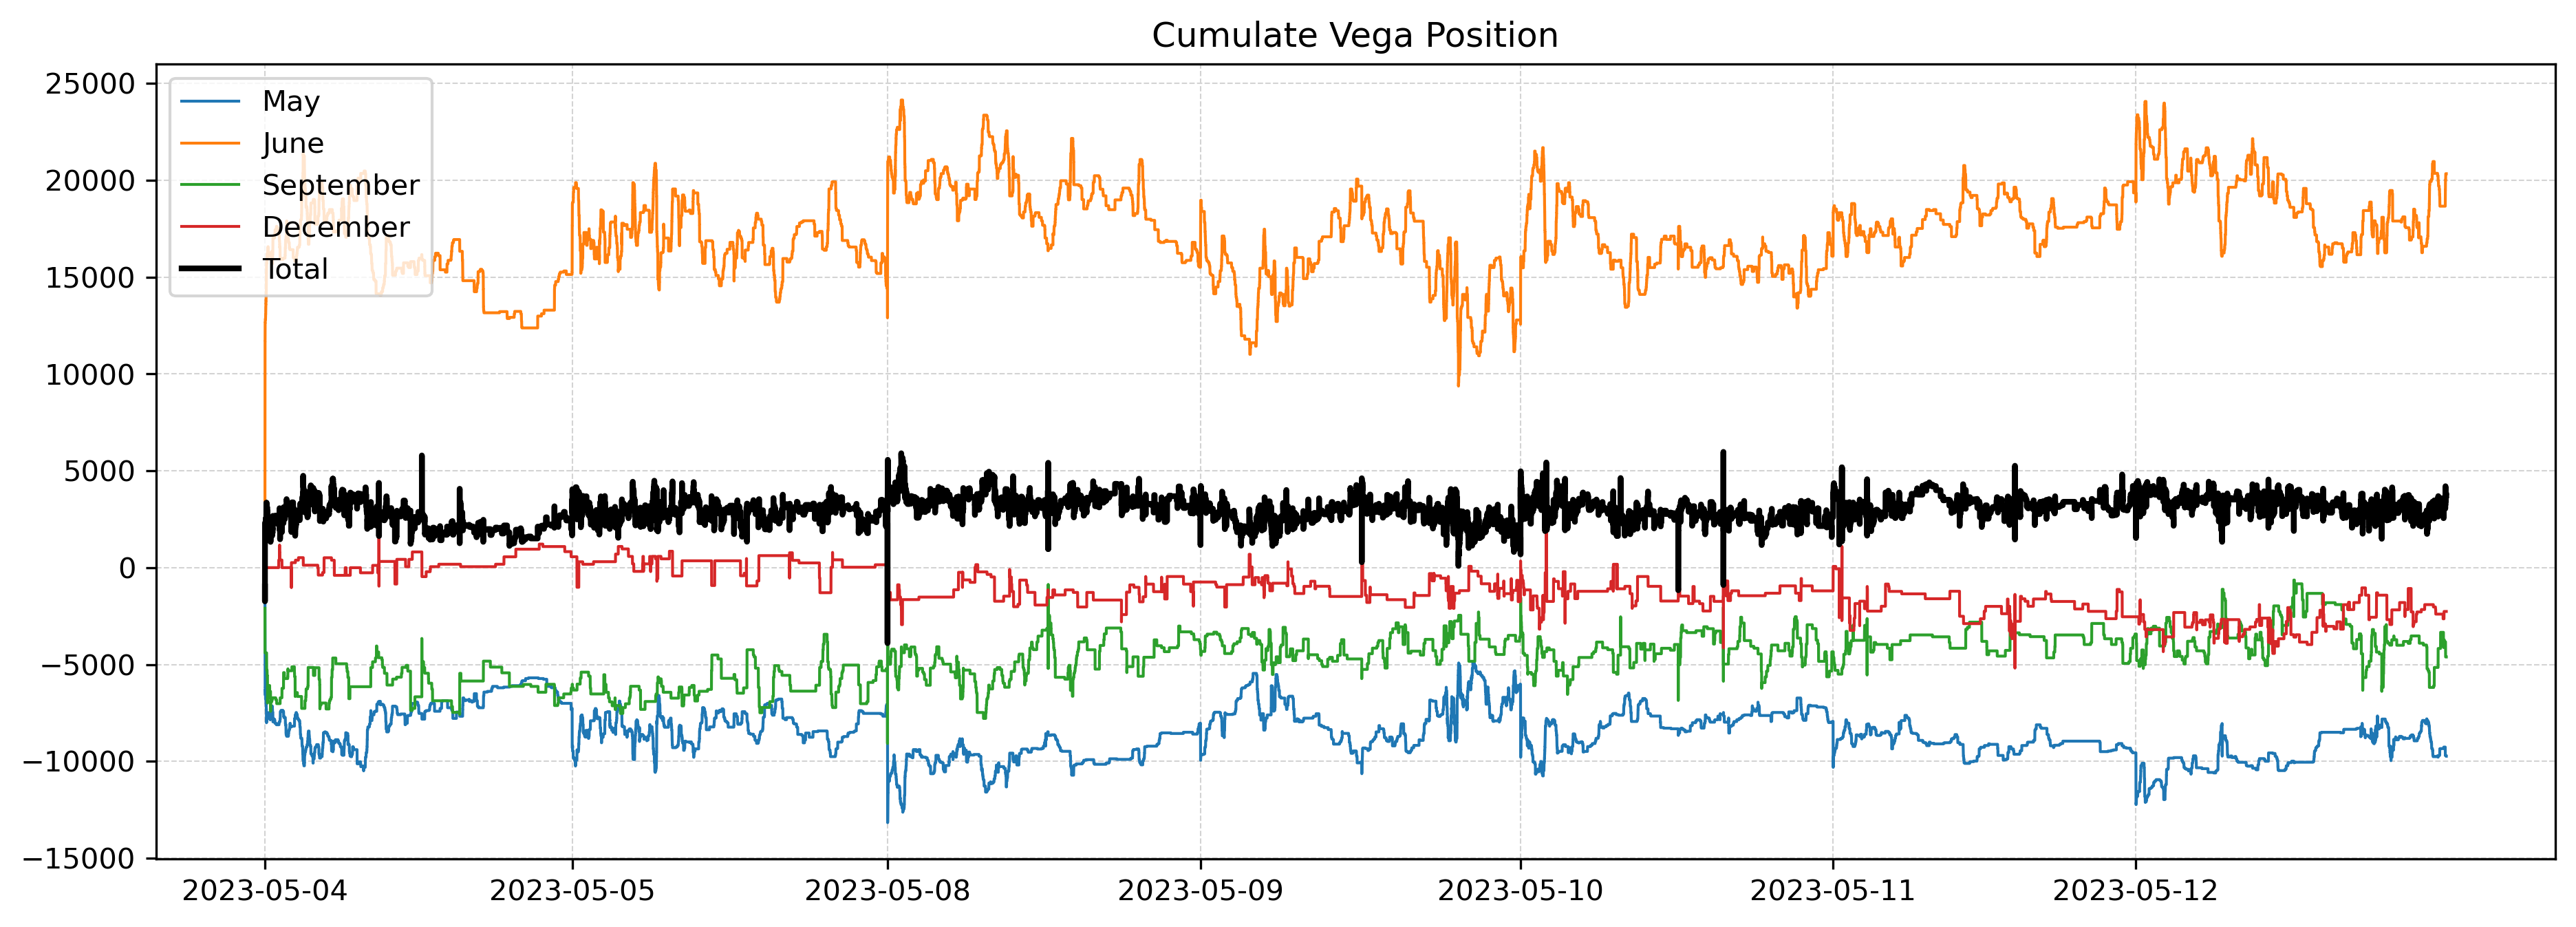

In [53]:
vega["Time"] = pd.to_datetime(vega["Time"])
daily_first_time = vega.groupby(vega["Time"].dt.date)["Time"].min()
data = vega.reset_index(drop=True)  # just to remove that pesky column

fig, ax = plt.subplots(1, 1, figsize=(15,5),dpi=300)
ax.plot(data.index, data["May"],label='May',linewidth= 1)
ax.plot(data.index, data["June"],label='June',linewidth= 1)
ax.plot(data.index, data["Sep"],label='September',linewidth= 1)
ax.plot(data.index, data["Dec"],label='December',linewidth= 1)
ax.plot(data.index, data["May"] +data["June"]+ data["Sep"]+data["Dec"],label='Total',color='black',linewidth= 2)
plt.xticks(
    data["Time"][data["Time"].apply(lambda x: x in daily_first_time.values)].index,
    daily_first_time.index,
)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.title('Cumulate Vega Position')

In [15]:
pnl1 = pnl_1[['Time','sub_ttl_pnl']].sort_values('Time').groupby('Time').sum().cumsum().reset_index()
pnl2 = pnl_2[['Time','sub_ttl_pnl']].sort_values('Time').groupby('Time').sum().cumsum().reset_index()
pnl3 = pnl_3[['Time','sub_ttl_pnl']].sort_values('Time').groupby('Time').sum().cumsum().reset_index()
pnl4 = pnl_4[['Time','sub_ttl_pnl']].sort_values('Time').groupby('Time').sum().cumsum().reset_index()

pnl1.rename(columns={'sub_ttl_pnl': 'May'}, inplace=True)
pnl2.rename(columns={'sub_ttl_pnl': 'June'}, inplace=True)
pnl3.rename(columns={'sub_ttl_pnl': 'Sep'}, inplace=True)
pnl4.rename(columns={'sub_ttl_pnl': 'Dec'}, inplace=True)

df_time = pnl1['Time']
pnl = pd.concat([df_time,pnl1['May'],pnl2['June'],pnl3['Sep'],pnl4['Dec']],axis='columns')

Text(0.5, 1.0, 'PnL')

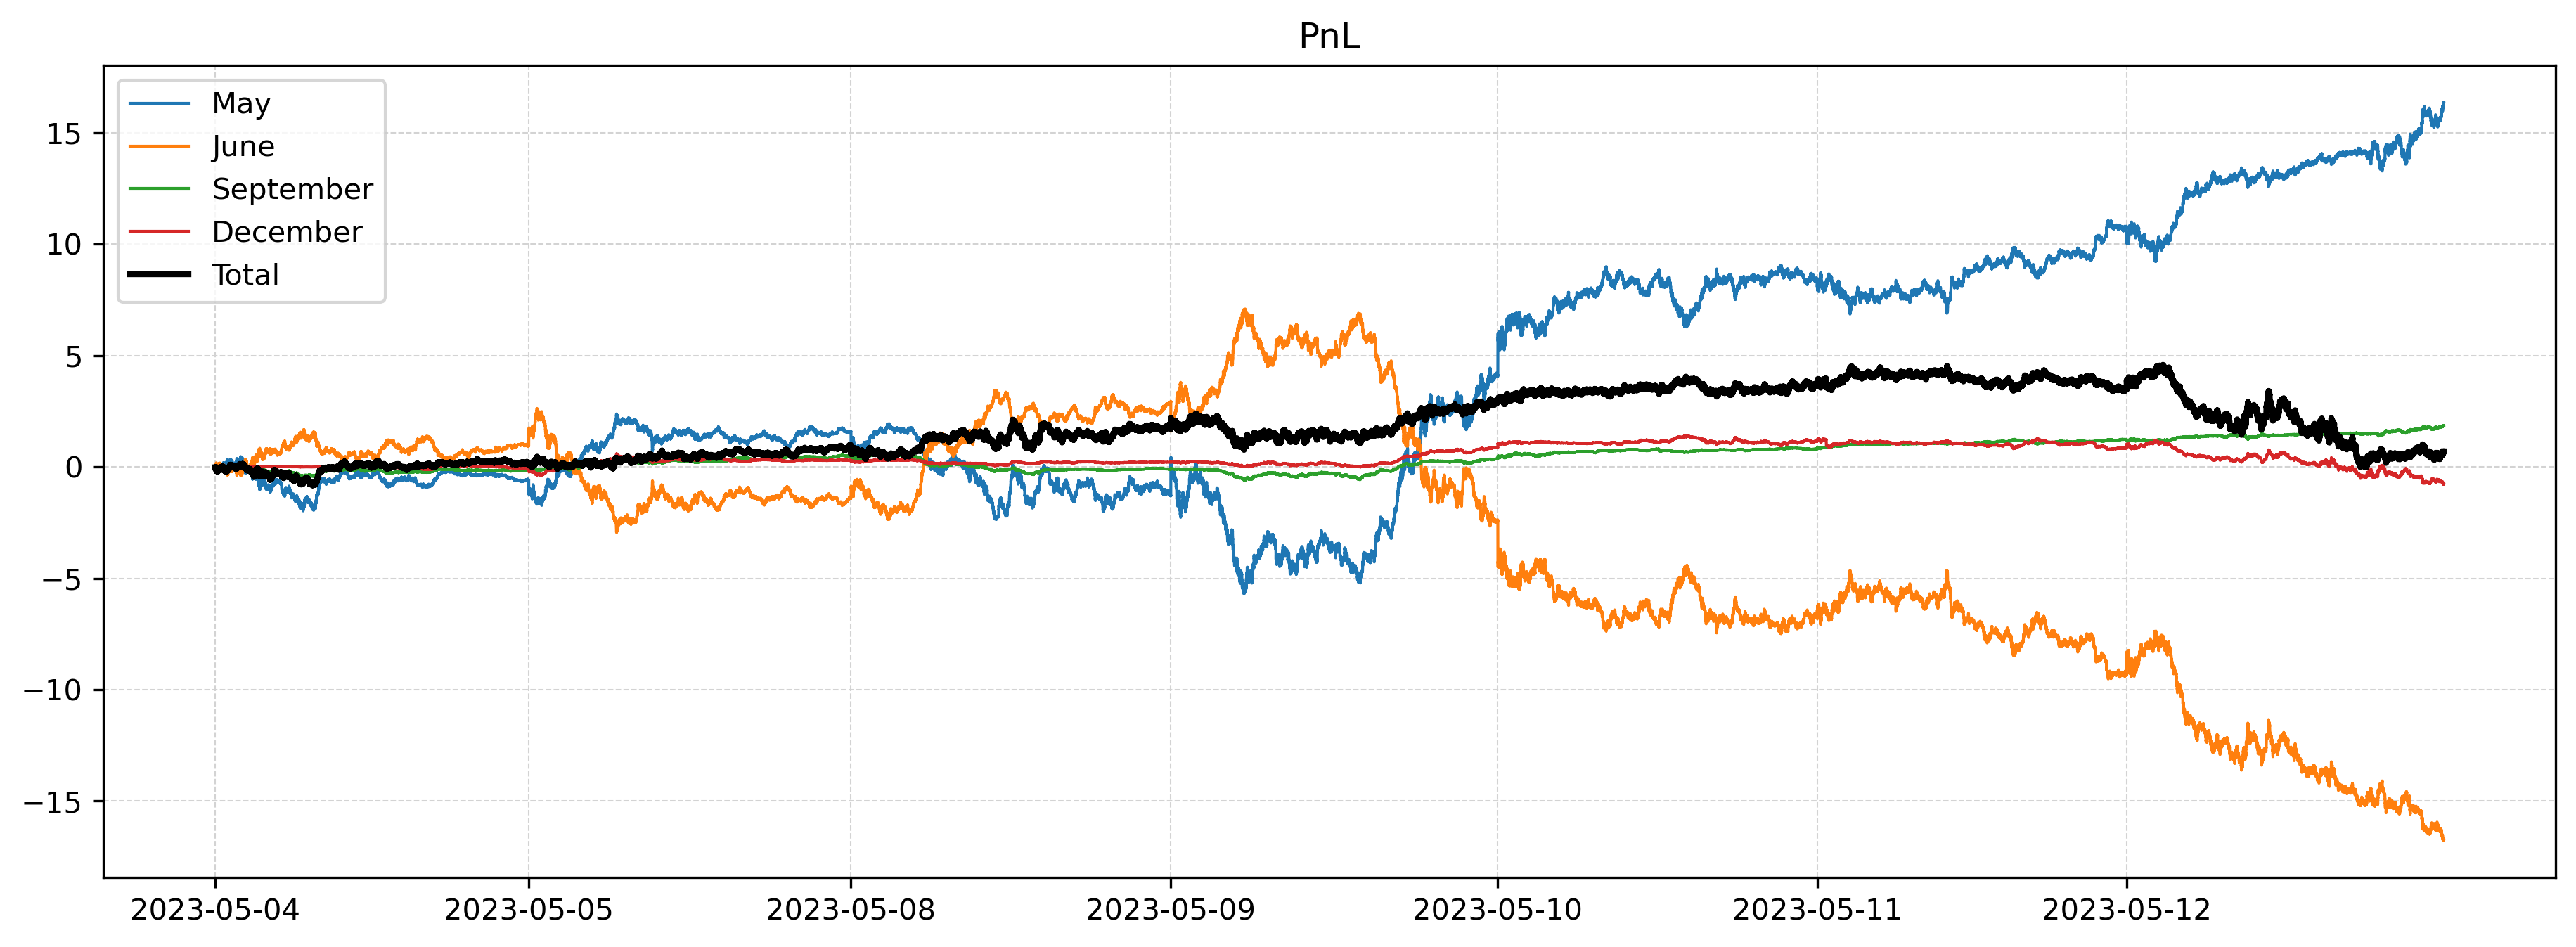

In [44]:
pnl["Time"] = pd.to_datetime(pnl["Time"])
daily_first_time = pnl.groupby(pnl["Time"].dt.date)["Time"].min()
data = pnl.reset_index(drop=True)  # just to remove that pesky column

fig, ax = plt.subplots(1, 1, figsize=(15,5),dpi=300)
ax.plot(data.index, data["May"],label='May',linewidth= 1)
ax.plot(data.index, data["June"],label='June',linewidth= 1)
ax.plot(data.index, data["Sep"],label='September',linewidth= 1)
ax.plot(data.index, data["Dec"],label='December',linewidth= 1)
ax.plot(data.index, data["May"] +data["June"]+ data["Sep"]+data["Dec"],label='Total',color='black',linewidth= 2)
plt.xticks(
    data["Time"][data["Time"].apply(lambda x: x in daily_first_time.values)].index,
    daily_first_time.index,
)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('PnL')